In [104]:
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix  
import re    
import plotnine as pln 
from matplotlib import pyplot as plt
import seaborn as sns



In [106]:
df_atp = pd.read_csv('df_atp.csv')


/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (15,21,22,28,31,47,48,52,55) have mixed types.Specify dtype option on import or set low_memory=False.


In [3]:
Cols = ['Best of',
'Court',
'Date',
'LPts',
 'LRank',
'Loser',
 'Round',
 'Series',
 'Surface',
 'Tournament',
'WPts',
 'WRank',
 'Winner','AvgW','AvgL','MaxW','MaxL']

In [4]:
df_atp['year'] = pd.DatetimeIndex(df_atp['Date']).year
df_atp_Train = df_atp[df_atp["year"]<2017]
df_atp_Test = df_atp[df_atp["year"]>=2017]

In [5]:
player = 'Agassi A.'

In [6]:
winner = df_atp_Train.loc[df_atp_Train.Winner==player,['Date', 'WRank']]
loser = df_atp_Train.loc[df_atp_Train.Loser==player,['Date','LRank']]
    
Ranking = pd.DataFrame({'Rank':pd.concat([winner.WRank, loser.LRank], axis=0),
                         'Date':pd.concat([winner.Date, loser.Date], axis=0)})
Ranking.sort_index(axis=0, inplace=True)

In [7]:
Ranking['Date'] = Ranking['Date'].apply(lambda x : x.year +(x.month-1)/12)

In [8]:
#pln.ggplot(Ranking, pln.aes(x='Date', y='Rank'))+pln.geom_point(pln.aes(colour='Rank'))+pln.scale_color_gradient(low='blue', high='yellow') 

In [9]:
Ranking["Rank"] = Ranking["Rank"].astype(float)
weight = np.polyfit(Ranking.Date, Ranking.Rank, 3)
model = np.poly1d(weight)
pred = np.round(model(Ranking.Date))
pred[pred<1] = 1

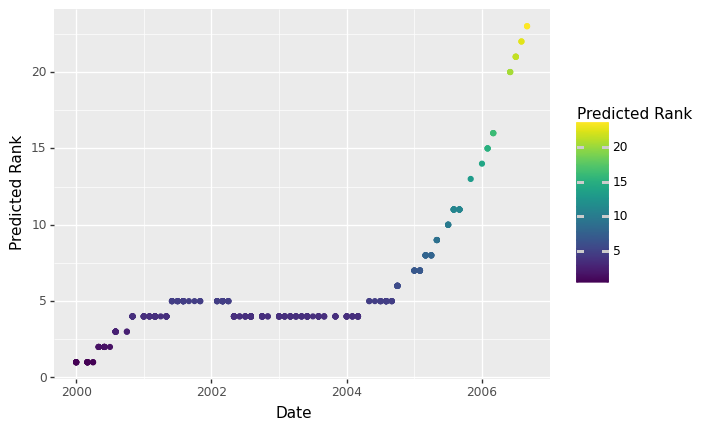

<ggplot: (-9223363243399772335)>

In [10]:
ggDateRankex = pln.ggplot(data = pd.DataFrame({'Date':Ranking.Date,'Predicted Rank':pred}))
ggDateRankex + pln.geom_point(pln.aes(x='Date',y='Predicted Rank',colour= 'Predicted Rank'))+ pln.theme_gray()

In [11]:
naRW= df_atp_Train.loc[:,'WRank'].apply(lambda x: x=='NR') ## COVERT EVERYTHING TO NAN
naRL = df_atp_Train.loc[:,'LRank'].apply(lambda x: x=='NR')
df_atp_Train.loc[naRW,'WRank'] = np.NaN
df_atp_Train.loc[naRL,'LRank'] = np.NaN

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
df_nan_RanksW = df_atp_Train.loc[df_atp_Train.WRank.isna(),['Date','Winner']].copy() 
df_nan_RanksL = df_atp_Train.loc[df_atp_Train.LRank.isna(),['Date','Loser']].copy() 
T = np.repeat(True, repeats=df_nan_RanksW.shape[0], axis=0)
F = np.repeat(False, repeats=df_nan_RanksL.shape[0], axis=0)

In [13]:
df_nan_Ranks = pd.DataFrame({'Date':pd.concat([df_nan_RanksW['Date'], df_nan_RanksL['Date']], axis=0),
                          'Player' : pd.concat([df_nan_RanksW['Winner'],df_nan_RanksL['Loser']], axis=0),
                         'isWinner':pd.Series(np.concatenate([T,F]).flatten(), 
                                            index=np.concatenate([df_nan_RanksW.index, df_nan_RanksL.index]))
                         })
df_nan_Ranks.sort_index(ascending=True, inplace=True)

In [14]:
df_nan_Ranks['DateFloat'] = df_nan_Ranks['Date'].apply(lambda x : x.year + (x.month-1)/12 + x.day/365)

In [15]:
medianRankW = np.median(df_atp_Train['WRank'])
medianRankL = np.median(df_atp_Train['LRank'])

In [16]:
def MedianRank(lenWin, lenLose, medianRankW = medianRankW, medianRankL =medianRankL):
   
    return(np.concatenate([np.repeat(medianRankW, repeats=lenWin, axis=0),
                           np.repeat(medianRankL, repeats=lenLose, axis=0)]).flatten())

In [17]:
def RankImput(Player, nanData = df_nan_Ranks ,sourceData = df_atp_Train):
    
    
    winData = sourceData.loc[sourceData.Winner==Player,['Date', 'WRank']]
    loseData = sourceData.loc[sourceData.Loser==Player,['Date','LRank']]
    
    playerNanData = nanData.loc[nanData['Player']==Player,:].copy()
    
    Ranking = pd.DataFrame({'Date':pd.concat([winData.Date, loseData.Date], axis=0), 
                             'Rank':pd.concat([winData.WRank, loseData.LRank], axis=0)})
    Ranking.sort_index(inplace=True)
    Ranking.dropna(inplace=True)
    Ranking['Date'] = Ranking['Date'].apply(lambda x : x.year + (x.month-1)/12)
    
    if(Ranking.shape[0]==0):
        return(pd.concat([playerNanData, pd.DataFrame({'PredRank':MedianRank(lenWin=len(winData),lenLose=len(loseData))},
                                                      index=playerNanData.index)], axis=1))
    
    ind = Ranking['Rank'].apply(lambda x : str(x).isalpha())
    ind = ind.index[ind]
    Ranking.drop(axis=0,index= ind, inplace=True)
    
    polyDegree = round(np.log10(len(Ranking)))     
    Ranking["Rank"] = Ranking["Rank"].astype(float)    
    weights = np.polyfit(Ranking.Date, Ranking.Rank, polyDegree)
    model = np.poly1d(weights)
    
    prediction = np.round(model(playerNanData['DateFloat']))
    prediction[prediction<1] = 1
    
    res = pd.concat([playerNanData, pd.DataFrame({'PredRank':prediction}, index=playerNanData.index)], axis=1)
    return(res)

In [18]:
def imputeRank(nanData = df_nan_Ranks ,sourceData = df_atp_Train, targetData = df_atp_Train):
    
    progress = 0
    nanPtsLen = len(nanData['Player'].unique())
    tenPer, per = nanPtsLen//10, 0
    for p in nanData['Player'].unique():
        imputations = RankImput(Player=p, nanData = nanData ,sourceData = sourceData)        
        for i,val in enumerate(imputations['isWinner']):
            imp = imputations.loc[imputations.index[i], 'PredRank']
            if (val): #Winner case
                targetData.loc[imputations.index[i],'WRank'] = imp
            else:     #Loser case
                targetData.loc[imputations.index[i],'LRank'] = imp
        if(per==progress):
            per += tenPer
        progress += 1
        if(progress==nanPtsLen):
            print("done")

In [19]:
imputeRank(nanData = df_nan_Ranks ,sourceData = df_atp_Train, targetData = df_atp_Train)

done


In [20]:
df_atp_Train['WRank'] = df_atp_Train['WRank'].astype('int64')
df_atp_Train['LRank'] = df_atp_Train['LRank'].astype('int64')

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
naRankIndWTest = df_atp_Test.loc[:,'WRank'].apply(lambda x: x=='NR') 
naRankIndLTest = df_atp_Test.loc[:,'LRank'].apply(lambda x: x=='NR')
df_atp_Test.loc[naRankIndWTest,'WRank'] = np.NaN
df_atp_Test.loc[naRankIndLTest,'LRank'] = np.NaN

In [22]:
df_atp_Test[df_atp_Test['LRank'].isna()] = 0
#resultSerie[resultSerie.isna()] = 0

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
df_atp_Test['WRank'] = df_atp_Test['WRank'].astype('int64')
df_atp_Test['LRank'] = df_atp_Test['LRank'].astype('int64')

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [24]:
#Players having missing points :
nanPointsPlayersW = df_atp_Train.loc[df_atp_Train.WPts.isna(),['WRank','Winner']].copy() 
nanPointsPlayersL = df_atp_Train.loc[df_atp_Train.LPts.isna(),['LRank','Loser']].copy() 
Trues = np.repeat(True, repeats=nanPointsPlayersW.shape[0], axis=0)
Falses = np.repeat(False, repeats=nanPointsPlayersL.shape[0], axis=0)
df_nan_Points = pd.DataFrame({'Player':pd.concat([nanPointsPlayersW['Winner'], nanPointsPlayersL['Loser']], axis=0),
                                 'Rank':pd.concat([nanPointsPlayersW['WRank'], nanPointsPlayersL['LRank']], axis=0),
                                 'isWinner':pd.Series(np.concatenate([Trues,Falses]).flatten(), 
                                            index=np.concatenate([nanPointsPlayersW.index, nanPointsPlayersL.index]))})


In [25]:
#Preparing data for training the average model Points = f(Rank)
cleanData = df_atp_Train.loc[:,['WRank','LRank','WPts','LPts']].copy()
cleanData.dropna(axis=0, inplace=True)

PtsSerie = pd.concat([cleanData.LPts, cleanData.WPts], axis=0)
RankSeries = pd.concat([cleanData.LRank, cleanData.WRank], axis=0)
df_rank_points = pd.DataFrame({'Rank':RankSeries,'Points': PtsSerie })

df_rank_points.sort_values(axis=0, by='Rank', inplace=True)

In [26]:
df_rank_points = df_rank_points.groupby('Rank').aggregate('median')

In [27]:
df_rank_points.reset_index(inplace=True)

In [28]:
XRank = df_rank_points.loc[:,'Rank'].values.reshape(-1, 1)
YRank = df_rank_points.loc[:,'Points'].values.reshape(-1, 1)

In [29]:
RfRegressor=RandomForestRegressor(n_estimators=3000, random_state=1995, min_samples_leaf=10, max_features=1)

In [30]:
RfRegressor.fit(XRank, YRank.squeeze())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=3000, n_jobs=None, oob_score=False,
                      random_state=1995, verbose=0, warm_start=False)

In [31]:
predictedPoints = RfRegressor.predict(XRank)

In [32]:
def avgRankPointPred(ranks ,model = RfRegressor):
    myr = np.array(ranks).reshape((len(ranks),1))
    pred = np.round(model.predict(myr))
    return(pred)

In [33]:
def computePointImput(Player, nanData = df_nan_Points ,targetData = df_atp_Train):
    
    winData = targetData.loc[targetData.Winner==Player,['WRank', 'WPts']]
    loseData = targetData.loc[targetData.Loser==Player,['LRank','LPts']]
    
    playerNanData = nanData.loc[nanData['Player']==Player,:].copy()
    
    PointData = pd.DataFrame({ 'Rank':pd.concat([winData['WRank'], loseData['LRank']], axis=0),
                             'Points':pd.concat([winData['WPts'], loseData['LPts']], axis=0)})
    PointData.sort_index(inplace=True)
    PointData.dropna(inplace=True)
    predPoints = avgRankPointPred(playerNanData['Rank'])
    output = pd.concat([playerNanData, pd.DataFrame({'PredPoint':predPoints}, index=playerNanData.index)], axis=1)
    return(output)

In [34]:
def imputePointsData(nanData = df_nan_Points ,targetData = df_atp_Train):
    progress = 0
    nanPtsLen = len(nanData['Player'].unique())
    tenPer, per = nanPtsLen//10, 0
    for p in nanData['Player'].unique():
        imputations = computePointImput(Player=p, nanData = nanData ,targetData = targetData)        
        for i,val in enumerate(imputations['isWinner']):
            imp = imputations.loc[imputations.index[i], 'PredPoint']
            if (val): #Winner case
                targetData.loc[imputations.index[i],'WPts'] = imp
            else:     #Loser case
                targetData.loc[imputations.index[i],'LPts'] = imp
        if(per==progress):
            print("Imputations in progress "+str( np.round(100*per/nanPtsLen, decimals=0))+"%")
            per += tenPer
        progress += 1
        if(progress==nanPtsLen):
            print("Done !")

In [35]:
imputePointsData(nanData = df_nan_Points ,targetData = df_atp_Train)

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Imputations in progress 0.0%


/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

Imputations in progress 10.0%


/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

Imputations in progress 20.0%


/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

Imputations in progress 30.0%


/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

Imputations in progress 40.0%


/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

Imputations in progress 50.0%


/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

Imputations in progress 60.0%


/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

Imputations in progress 69.0%


/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

Imputations in progress 79.0%


/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

Imputations in progress 89.0%


/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

Imputations in progress 99.0%


/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

Done !


/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [36]:
df_atp_Train['WPts'] = df_atp_Train['WPts'].astype('int64')
df_atp_Train['LPts'] = df_atp_Train['LPts'].astype('int64')

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [37]:
#Players having missing points :
nanPointsPlayersL_T = df_atp_Test.loc[df_atp_Test.LPts.isna(),['LRank','Loser']].copy() 
FalsesT = np.repeat(False, repeats=nanPointsPlayersL_T.shape[0], axis=0)
df_nan_Points_Test = pd.DataFrame({'Player':nanPointsPlayersL_T['Loser'],
                                 'Rank':nanPointsPlayersL_T['LRank'],
                                 'isWinner':pd.Series(FalsesT, index = nanPointsPlayersL_T.index)
                                  })



In [38]:
imputePointsData(nanData = df_nan_Points_Test ,targetData = df_atp_Test)

In [39]:
df_atp_Test['WPts'] = df_atp_Test['WPts'].astype('int64')
df_atp_Test['LPts'] = df_atp_Test['LPts'].astype('int64')

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [40]:
df_atp_Train[['Player1','Player2']] = df_atp_Train.loc[:,['Winner','Loser']]
df_atp_Train.head(50)

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL,year,Player1,Player2
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,Dosedel S.,Ljubicic I.
1,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Enqvist T.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,Enqvist T.,Clement A.
2,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Escude N.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,Escude N.,Baccanello P.
3,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Federer R.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,Federer R.,Knippschild J.
4,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Fromberg R.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,Fromberg R.,Woodbridge T.
5,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Gambill J.M.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,Gambill J.M.,Arthurs W.
6,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Grosjean S.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,Grosjean S.,Ilie A.
7,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Henman T.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,Henman T.,Balcells J.
8,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Hewitt L.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,Hewitt L.,Woodforde M.
9,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Lisnard J.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,Lisnard J.,Tebbutt M.


In [41]:
np.random.seed(1)

In [42]:
Won = np.random.randint(2,size=len(df_atp_Train))

In [43]:
df_atp_Train['Won'] = Won
boolWon = (Won==0)

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [44]:
df_atp_Train.loc[boolWon,'Player1'] , df_atp_Train.loc[boolWon,'Player2'] = df_atp_Train.loc[boolWon,'Player2'], df_atp_Train.loc[boolWon,'Player1'] 

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [45]:
df_atp_Test[['Player1','Player2']] = df_atp_Test.loc[:,['Winner','Loser']]
df_atp_Test.head()
WonT = np.random.randint(2,size=len(df_atp_Test))
df_atp_Test['Won'] = WonT
boolWonT = (WonT==0)

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [46]:
df_atp_Test.loc[boolWonT,'Player1'] , df_atp_Test.loc[boolWonT,'Player2'] = df_atp_Test.loc[boolWonT,'Player2'], df_atp_Test.loc[boolWonT,'Player1'] 

In [47]:
df_atp_Train["RankDiff"] = 0
df_atp_Train["PtsDiff"] = 0
df_atp_Train["OddsDiff"] = 0
df_atp_Train["MaxOddsDiff"] = 0

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [48]:
def pDiff(variable = 'Rank', targetData=df_atp_Train):
    if variable == 'Rank':
        Wval, Lval = 'WRank', 'LRank'
        target = "RankDiff"
        differences = targetData[Lval]-targetData[Wval]
    elif variable == 'Point':
        Wval, Lval = 'WPts', 'LPts'
        target = "PtsDiff"
        differences = targetData[Wval]-targetData[Lval]
    elif variable == "Odds":
        Wval,Lval = 'AvgW', 'AvgL'
        target = "OddsDiff"
        differences = targetData[Wval]-targetData[Lval]
    elif variable == "MAX":
        Wval,Lval = 'MaxW', 'MaxL'
        target = "MaxOddsDiff"
        differences = targetData[Wval]-targetData[Lval]
        
    targetData[target] = differences
    won = targetData['Won'] == 0    
    targetData.loc[won,target] = targetData.loc[won,target].apply(lambda x : -x)

In [49]:
pDiff(variable='Rank', targetData=df_atp_Train)
pDiff(variable='Odds', targetData=df_atp_Train)
pDiff(variable='Point', targetData=df_atp_Train)
pDiff(variable='MAX', targetData=df_atp_Train)

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [50]:
df_atp_Test["RankDiff"] = 0
df_atp_Test["PtsDiff"] = 0
df_atp_Test["OddsDiff"] = 0
df_atp_Test["MaxOddsDiff"] = 0

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [51]:
pDiff(variable='Rank', targetData=df_atp_Test)
pDiff(variable='Point', targetData=df_atp_Test)
pDiff(variable='Odds', targetData = df_atp_Test)
pDiff(variable='MAX', targetData = df_atp_Test)

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [52]:
uniquePlayers =df_atp_Train.loc[:,['Winner','Loser']].unstack().unique()

In [53]:
df_atp_Train.head()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,AvgW,AvgL,year,Player1,Player2,Won,RankDiff,PtsDiff,OddsDiff,MaxOddsDiff
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,...,NaN,NaN,2000,Dosedel S.,Ljubicic I.,1,14,118,NaN,NaN
1,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Enqvist T.,...,NaN,NaN,2000,Enqvist T.,Clement A.,1,51,3426,NaN,NaN
2,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Escude N.,...,NaN,NaN,2000,Baccanello P.,Escude N.,0,-615,-1036,NaN,NaN
3,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Federer R.,...,NaN,NaN,2000,Knippschild J.,Federer R.,0,-22,-161,NaN,NaN
4,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Fromberg R.,...,NaN,NaN,2000,Fromberg R.,Woodbridge T.,1,117,370,NaN,NaN


In [54]:
df_Unique_Players = pd.DataFrame({'Player':uniquePlayers,'FirstRounds':0, 
                                  'Quarterfinals':0, 'Semifinals': 0, 'Final':0,
                                 'WeightedSum':0})
genSerie = pd.Series({'1st Round':0, '2nd Round': 0, '3rd Round':0, '4th Round':0,'Quarterfinals':0,'Round Robin':0,
          'Semifinals':0,'The Final':0 })

In [55]:
def roundWin(data = df_atp_Train, genSerie = genSerie, targetData = df_Unique_Players, inplace = True):
    progress = 0
    playersLen = len(targetData)
    tenPer, per = playersLen//10, 0
    
    roundWeights = np.array([0.1,0.2,0.3,0.4,0.6,0,0.7,0.9])  
                                                              
    
    if(not inplace):
        targetData = targetData.copy()
        
    for i, player in enumerate(targetData['Player']):
        resultSerie = genSerie.copy()
        playerW = data.loc[data['Winner']==player,'Round']
        playerL = data.loc[data['Loser']==player,'Round']
        
        perRoundVictories = playerW.value_counts()
        perRoundLosses = playerL.value_counts()
        
        totalResults = perRoundVictories+perRoundLosses
        victoryFractions = perRoundVictories/totalResults
        
        resultSerie[victoryFractions.keys()] = victoryFractions
        resultSerie[resultSerie.isna()] = 0
        
        FirstRounds = np.mean(resultSerie[0:4].values)    
        Quarterfinals = resultSerie['Quarterfinals']      
        Semifinals = resultSerie['Semifinals']            
        Final = resultSerie['The Final']                  
        
        weightedVals = np.sum(roundWeights * resultSerie.values) 
        
        targetData.loc[i,'FirstRounds'] = FirstRounds
        targetData.loc[i,'Quarterfinals'] = Quarterfinals
        targetData.loc[i,'Semifinals'] = Semifinals
        targetData.loc[i,'Final'] = Final
        targetData.loc[i,'WeightedSum'] = weightedVals
        
        
       

In [56]:
roundWin(data = df_atp_Train, genSerie = genSerie, targetData = df_Unique_Players, inplace=True)

In [57]:
df_atp_Train['WeightedRndDiff'] = 0  
df_atp_Train['RoundDiff'] = 0         

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [58]:
def RoundDiff(sourceData = df_Unique_Players, targetData = df_atp_Train, forTestData = False):
    if(forTestData):
        sourceData = sourceData.copy()
        uniquePlayersT =targetData.loc[:,['Winner','Loser']].unstack().unique()
        df_Unique_Players_T = pd.DataFrame({'Player':uniquePlayersT,'FirstRounds':0, 
                                  'Quarterfinals':0, 'Semifinals': 0, 'Final':0,
                                 'WeightedSum':0})
        newPlayersInd = df_Unique_Players_T['Player'].apply(lambda x : x not in df_Unique_Players['Player'].values)
        df_Unique_Players_T = df_Unique_Players_T.loc[newPlayersInd,:]
        sourceData = pd.concat([df_Unique_Players,df_Unique_Players_T], axis=0)
        
    
    progress = 0
    playersLen = len(targetData)
    tenPer, per = playersLen//10, 0
    
    for i in range(len(targetData)):
        p1 = targetData.loc[targetData.index[i],'Player1']
        p2 = targetData.loc[targetData.index[i],'Player2']
        matchRound = targetData.loc[targetData.index[i],'Round']
        
        wSump1 = sourceData.loc[sourceData['Player']==p1,'WeightedSum']
        wSump2 = sourceData.loc[sourceData['Player']==p2,'WeightedSum']
                    
        
        diffW = wSump1.values - wSump2.values
        targetData.loc[targetData.index[i],'WeightedRndDiff'] = diffW
        
        if 'Round' in matchRound:
            roundValP1 = sourceData.loc[sourceData['Player']==p1,'FirstRounds']
            roundValP2 = sourceData.loc[sourceData['Player']==p2,'FirstRounds']
        elif matchRound == 'Quarterfinals':
            roundValP1 = sourceData.loc[sourceData['Player']==p1,'Quarterfinals']
            roundValP2 = sourceData.loc[sourceData['Player']==p2,'Quarterfinals']
        elif matchRound == 'Semifinals':
            roundValP1 = sourceData.loc[sourceData['Player']==p1,'Semifinals']
            roundValP2 = sourceData.loc[sourceData['Player']==p2,'Semifinals']
        elif matchRound == 'The Final':
            roundValP1 = sourceData.loc[sourceData['Player']==p1,'Final']
            roundValP2 = sourceData.loc[sourceData['Player']==p2,'Final']
        else:
            roundValP1 = wSump1
            roundValP2 = wSump2
        
        diff = roundValP1.values - roundValP2.values
        targetData.loc[targetData.index[i],'RoundDiff'] = diff
        
            
        if(per==progress):
            print("Computations in progress "+str( np.round(100*per/playersLen, decimals=0))+"%")
            per += tenPer
        progress += 1
        if(progress==playersLen):
            print("Done !")
        

In [59]:
RoundDiff(sourceData = df_Unique_Players, targetData = df_atp_Train)

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Computations in progress 0.0%
Computations in progress 10.0%
Computations in progress 20.0%
Computations in progress 30.0%
Computations in progress 40.0%
Computations in progress 50.0%
Computations in progress 60.0%
Computations in progress 70.0%
Computations in progress 80.0%
Computations in progress 90.0%
Computations in progress 100.0%
Done !


In [60]:
df_atp_Test['WeightedRndDiff'] = 0   
df_atp_Test['RoundDiff'] = 0         

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Modeling  

In [61]:
Cols = np.array(['Won','year','Court','Round','Surface','RankDiff','PtsDiff','OddsDiff','WeightedRndDiff','RoundDiff'])#,'p1Vsp2','Wp1Vsp2' ])

In [62]:
TrainData = df_atp_Train.loc[:,Cols].copy()
TrainX = TrainData.loc[:,'Won'!=Cols]
TrainY = TrainData.loc[:,'Won']
TestData = df_atp_Test.loc[:,Cols].copy()
TestX = TestData.loc[:,'Won'!=Cols]
TestY = TestData.loc[:,'Won']


In [65]:
courtCats = TrainX.Court.unique()
CourtCat = pd.DataFrame({'CourtCat':TrainX.Court.unique()})
CourtCat

,CourtCat
0,Outdoor
1,Indoor


In [66]:
surfCats = TrainX.Surface.unique()
SurfaceCategories = pd.DataFrame({'SurfaceCat':TrainX.Surface.unique()})
SurfaceCategories

,SurfaceCat
0,Hard
1,Clay
2,Grass
3,Carpet


In [67]:
roundCats = TrainX.Round.unique()
RoundCategories = pd.DataFrame({'RoundCat':TrainX.Round.unique()})
RoundCategories

,RoundCat
0,1st Round
1,2nd Round
2,Quarterfinals
3,Semifinals
4,The Final
5,3rd Round
6,4th Round
7,Round Robin


In [68]:
surfaceDummiesTrain = pd.get_dummies(TrainX,columns= np.array(['Surface']), prefix='', prefix_sep='')
surfaceDummiesTrain = surfaceDummiesTrain.T.reindex(surfCats).T.fillna(0)
surfaceDummiesTrain = surfaceDummiesTrain.loc[:,surfCats]

In [69]:
surfaceDummiesTest = pd.get_dummies(TestX,columns= np.array(['Surface']), prefix='', prefix_sep='')
surfaceDummiesTest = surfaceDummiesTest.T.reindex(surfCats).T.fillna(0)
surfaceDummiesTest = surfaceDummiesTest.loc[:,surfCats]

In [70]:
courtDummiesTrain = pd.get_dummies(TrainX,columns= np.array(['Court']), prefix='', prefix_sep='')
courtDummiesTrain = courtDummiesTrain.T.reindex(courtCats).T.fillna(0)
courtDummiesTrain = courtDummiesTrain.loc[:,courtCats]

In [71]:
courtDummiesTest = pd.get_dummies(TestX,columns= np.array(['Court']), prefix='', prefix_sep='')
courtDummiesTest = courtDummiesTest.T.reindex(courtCats).T.fillna(0)
courtDummiesTest = courtDummiesTest.loc[:,courtCats]

In [72]:
roundDummiesTrain = pd.get_dummies(TrainX,columns= np.array(['Round']), prefix='', prefix_sep='')
roundDummiesTrain = roundDummiesTrain.T.reindex(roundCats).T.fillna(0)
roundDummiesTrain = roundDummiesTrain.loc[:,roundCats]

In [73]:
roundDummiesTest = pd.get_dummies(TestX,columns= np.array(['Round']), prefix='', prefix_sep='')
roundDummiesTest = roundDummiesTest.T.reindex(roundCats).T.fillna(0)
roundDummiesTest = roundDummiesTest.loc[:,roundCats]

In [74]:
TrainX = pd.concat([TrainX, surfaceDummiesTrain, courtDummiesTrain, roundDummiesTrain], axis=1)
TestX = pd.concat([TestX, surfaceDummiesTest, courtDummiesTest, roundDummiesTest], axis=1)

In [75]:
TrainX.drop(axis=1,columns=['Court','Surface', 'Round'], inplace=True)

In [76]:
TestX.drop(axis=1,columns=['Court','Surface','Round'], inplace=True)

In [77]:
TrainX["OddsDiff"] = TrainX["OddsDiff"].fillna(0)
TestX["OddsDiff"] = TestX["OddsDiff"].fillna(0)

In [78]:

from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

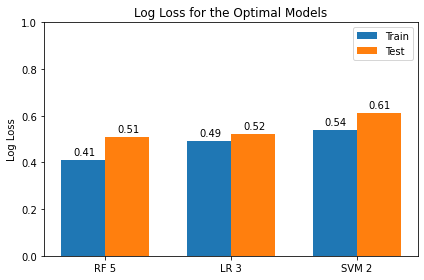

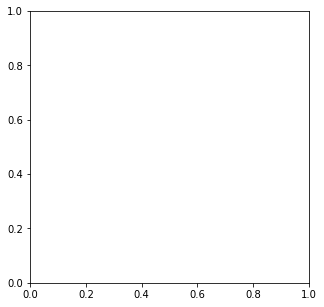

In [79]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['RF 5', 'LR 3', 'SVM 2']
Train_means = [0.41, 0.49, 0.54]
Test_means = [0.51, 0.52, 0.61]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Train_means, width, label='Train')
rects2 = ax.bar(x + width/2, Test_means, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Log Loss')
ax.set_title('Log Loss for the Optimal Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
#plt.figsize(5,5)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 1.9, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.ylim([0.0, 1])
plt.subplots(figsize=(5,5))
plt.show()

## ADABOOST

In [80]:
classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=5000)
classifier.fit(TrainX,TrainY)
predictions = classifier.predict(TestX)
print("train ",classifier.score(TestX,TestY))
print("test ",classifier.score(TrainX,TrainY))

train  0.6652751423149905
test  0.6953729692948881


## LOGISTIC REGRESSION TUNING


## LR VALIDATION CURVES

In [81]:
#from sklearn.linear_model import LogisticRegressionCV
#from sklearn.ensemble import RandomForestClassifier
#import numpy as np
#import matplotlib.pyplot as plt


#clf = LogisticRegressionCV(max_iter=3000)
#clf.fit(TrainX,TrainY)
#coefs = np.abs(clf.coef_[0])
#indices = np.argsort(coefs)[::-1]

#plt.figure()
#plt.title("Feature importances (Logistic Regression)")
#plt.bar(range(10), coefs[indices[:10]],
 #      color="skyblue", align="center")
#plt.xticks(range(10), feats[indices[:10]], rotation=45, ha='right')
#plt.subplots_adjust(bottom=0.3)
#
#plt.ion(); 
#plt.show()

## LR VALIDATION

In [82]:
from sklearn.model_selection import GridSearchCV,cross_val_predict
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(TrainX,TrainY)
predicted = cross_val_predict(logreg,TrainX,TrainY,cv=10)
print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
print("validation accuracy :",logreg_cv.best_score_)
# print how our model looks after hyper-parameter tuning 
print(logreg_cv.best_estimator_) 




/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the document

tuned hyperparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2'}
validation accuracy : 0.6833599520582581
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [83]:
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
feature_scaler = StandardScaler()
#TrainX1 = feature_scaler.fit_transform(TrainX)
#TestX1 = feature_scaler.fit_transform(TestX)
#logisticRegr = LogisticRegression(C=100000 ,penalty = "l1)
logreg=LogisticRegression(C=100000)
logreg1 = logreg.fit(TrainX,TrainY)
predictions = logreg1.predict(TestX)
logreg.score(TestX,TestY)

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.6688804554079696

## LR TEST

In [84]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

print(confusion_matrix(TestY, predictions))
print (classification_report(TestY, predictions) )
print(accuracy_score(TestY,predictions))

[[1676  971]
 [ 774 1849]]
              precision    recall  f1-score   support

           0       0.68      0.63      0.66      2647
           1       0.66      0.70      0.68      2623

    accuracy                           0.67      5270
   macro avg       0.67      0.67      0.67      5270
weighted avg       0.67      0.67      0.67      5270

0.6688804554079696


## LOGISTIC REGRESSION ROC FOR TRAIN AND TEST

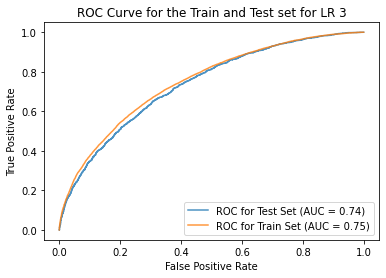

In [85]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

#rf_Fit01=RandomForestClassifier(n_estimators=3000, random_state=1995, min_samples_leaf=20, max_features=20, criterion='entropy' )

logreg3 = LogisticRegression()
logreg3.fit(TrainX,TrainY)
ax = plt.gca()
logreg3_disp = plot_roc_curve(logreg3,TestX,TestY, ax=ax, alpha=0.8,name = "ROC for Test Set")
logreg3_disp = plot_roc_curve(logreg3,TrainX,TrainY, ax=ax, alpha=0.8,name = "ROC for Train Set")
plt.title('ROC Curve for the Train and Test set for LR 3')
#svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

## LOGREG ROC FOR BEST AND WORST MODEL

In [86]:
logreg1 = LogisticRegression(C=10000,solver='saga',penalty = 'l1').fit(TrainX,TrainY)
predictions = logreg1.predict(TestX)
logreg1.score(TestX,TestY)

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


0.6409867172675522

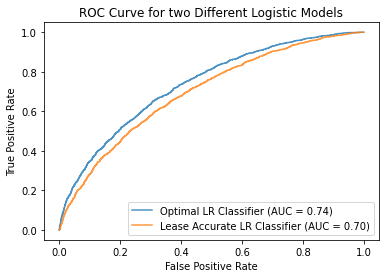

In [87]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

#rf_Fit02=RandomForestClassifier(n_estimators=1, random_state=1995, min_samples_leaf=20, max_features=1, criterion='entropy' )


#rfc = RandomForestClassifier(n_estimators=10, random_state=42)
#rf_Fit02.fit(TrainX,TrainY)
ax = plt.gca()
logreg3_disp = plot_roc_curve(logreg3,TestX,TestY, ax=ax, alpha=0.8,name = "Optimal LR Classifier")
logreg1_disp = plot_roc_curve(logreg1,TestX,TestY, ax=ax, alpha=0.8,name="Lease Accurate LR Classifier")
plt.title("ROC Curve for two Different Logistic Models")
#svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

## CV FOR LOGISTIC REGRESSION

AttributeError: 'AxesSubplot' object has no attribute 'set_axis_bgcolor'

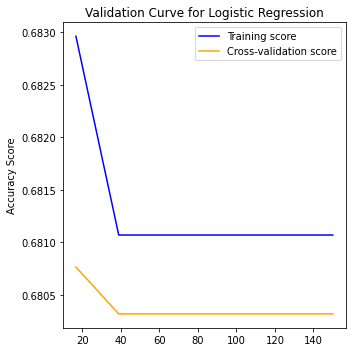

In [88]:
from sklearn.model_selection import validation_curve

# Plot Validation Curve
# Create range of values for parameter
param_range = np.linspace(-50, 150, 10)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(LogisticRegression(),
TrainX, TrainY, param_name="C", param_range=param_range,
cv=4, scoring="accuracy", n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.subplots(1, figsize=(5,5))
plt.plot(param_range, train_mean, label="Training score", color="Blue")
plt.plot(param_range, test_mean, label="Cross-validation score", color="orange")
# Plot accurancy bands for training and test sets
#plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="orange")
#plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="moccasin")
# Create plot    
plt.title("Validation Curve for Logistic Regression")
plt.xlabel("")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
ax.set_axis_bgcolor("white")
plt.show()



AttributeError: 'AxesSubplot' object has no attribute 'set_axis_bgcolor'

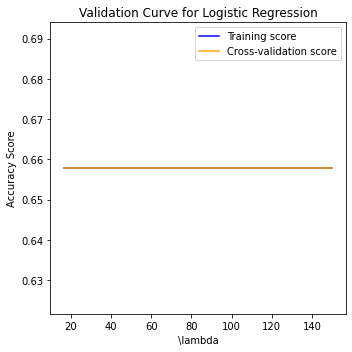

In [89]:
from sklearn.model_selection import validation_curve

# Plot Validation Curve
# Create range of values for parameter
param_range = np.linspace(-50, 150, 10)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(LogisticRegression(penalty = 'l1',solver = 'saga'),
TrainX, TrainY, param_name="C", param_range=param_range,
cv=4, scoring="accuracy", n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.subplots(1, figsize=(5,5))
plt.plot(param_range, train_mean, label="Training score", color="Blue")
plt.plot(param_range, test_mean, label="Cross-validation score", color="orange")
# Plot accurancy bands for training and test sets
#plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="orange")
#plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="moccasin")
# Create plot    
plt.title("Validation Curve for Logistic Regression")
plt.xlabel("\lambda")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
ax.set_axis_bgcolor("lightslategray")
plt.show()




## SVM

In [90]:
from sklearn.svm import LinearSVC,SVC
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score
#from sklearn.linear_model import LogisticRegression
feature_scaler = StandardScaler()
TrainX1 = feature_scaler.fit_transform(TrainX)
TestX1 = feature_scaler.fit_transform(TestX)
svc = LinearSVC()
svc = svc.fit(TrainX1,TrainY)
svc_predict = svc.predict(TestX1)
svc_conf_matrix = confusion_matrix(TestY, svc_predict)
svc_acc_score = accuracy_score(TestY, svc_predict)
print(svc_conf_matrix)
print("test :" , svc_acc_score*100)
print(classification_report(TestY,svc_predict))
svc_predict1 = svc.predict(TrainX)

print("train :" , accuracy_score(TrainY, svc_predict1))

[[1692  955]
 [ 827 1796]]
test : 66.18595825426945
              precision    recall  f1-score   support

           0       0.67      0.64      0.66      2647
           1       0.65      0.68      0.67      2623

    accuracy                           0.66      5270
   macro avg       0.66      0.66      0.66      5270
weighted avg       0.66      0.66      0.66      5270

train : 0.6459556009186017


/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.


## PLOT TRAIN TEST ROC

## PLOTTING DIFFERENT MODEL ROC

/Users/jayantjuneja/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.


AttributeError: 'AxesSubplot' object has no attribute 'set_axis_bgcolor'

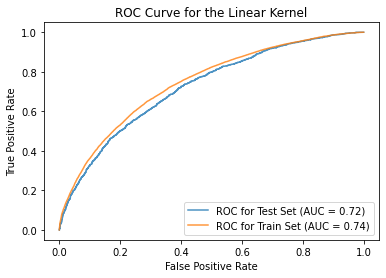

In [91]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

#rf_Fit01=RandomForestClassifier(n_estimators=3000, random_state=1995, min_samples_leaf=20, max_features=20, criterion='entropy' )

svc = LinearSVC()
svc = svc.fit(TrainX,TrainY)
#rfc = RandomForestClassifier(n_estimators=10, random_state=42)
#rf_Fit01.fit(TrainX,TrainY)
ax = plt.gca()
svc_disp = plot_roc_curve(svc,TestX,TestY, ax=ax, alpha=0.8,name = "ROC for Test Set")
svc_disp = plot_roc_curve(svc,TrainX,TrainY, ax=ax, alpha=0.8,name = "ROC for Train Set")
plt.title("ROC Curve for the Linear Kernel")
ax.set_axis_bgcolor("white")
#svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

## VALIDATION CURVE

AttributeError: 'AxesSubplot' object has no attribute 'set_axis_bgcolor'

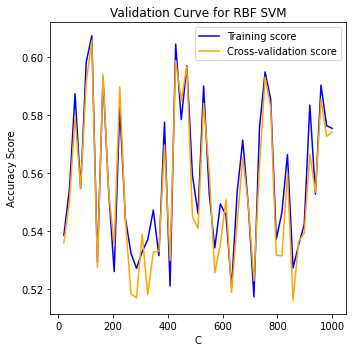

In [92]:
from sklearn.model_selection import validation_curve

# Plot Validation Curve
# Create range of values for parameter
param_range = np.linspace(0,1000,50)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(LinearSVC(),
TrainX, TrainY, param_name="C", param_range=param_range,
cv=5, scoring="accuracy", n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.subplots(1, figsize=(5,5))
plt.plot(param_range, train_mean, label="Training score", color="Blue")
plt.plot(param_range, test_mean, label="Cross-validation score", color="orange")
# Plot accurancy bands for training and test sets
#plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="orange")
#plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="moccasin")
# Create plot    
plt.title("Validation Curve for RBF SVM")
plt.xlabel("C")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
ax.set_axis_bgcolor("white")
plt.show()




### Tuning Random Forest

In [93]:
rf_Fit0=RandomForestClassifier(n_estimators=5000, random_state=1995, min_samples_leaf=20, max_features=20, criterion='entropy' )
rf_Fit0.fit(TrainX,TrainY)

rf_Fit0.score(TestX, TestY)
rf_Fit02=RandomForestClassifier(n_estimators=1, random_state=1995, min_samples_leaf=20, max_features=1, criterion='entropy' )


#rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rf_Fit02.fit(TrainX,TrainY)
rf_Fit02.score(TestX, TestY)
print('test score',rf_Fit02.score(TestX, TestY))
rf_Fit02.fit(TrainX,TrainY)
print('train score',rf_Fit02.score(TrainX,TrainY))

test score 0.5066413662239089
train score 0.6757463638683338


In [95]:
rf_Fit0_predict = rf_Fit0.predict(TestX)
rf_Fit0_conf_matrix = confusion_matrix(TestY, rf_Fit0_predict)
rf_Fit0_acc_score = accuracy_score(TestY, rf_Fit0_predict)
print(rf_Fit0_conf_matrix)
print("test :" , rf_Fit0_acc_score*100)
print(classification_report(TestY,rf_Fit0_predict))


[[1627 1020]
 [ 681 1942]]
test : 67.72296015180265
              precision    recall  f1-score   support

           0       0.70      0.61      0.66      2647
           1       0.66      0.74      0.70      2623

    accuracy                           0.68      5270
   macro avg       0.68      0.68      0.68      5270
weighted avg       0.68      0.68      0.68      5270



## PLOT ACCURACY

## PLOTTING TRAIN TEST ROC

## PLOTTING DIFFERENT MODEL ROC

AttributeError: 'AxesSubplot' object has no attribute 'set_axis_bgcolor'

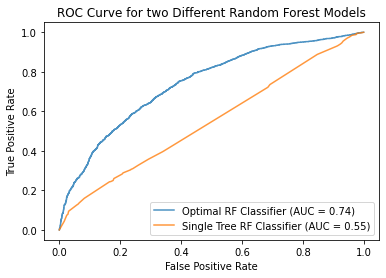

In [98]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

rf_Fit02=RandomForestClassifier(n_estimators=1, random_state=1995, min_samples_leaf=20, max_features=1, criterion='entropy' )


#rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rf_Fit02.fit(TrainX,TrainY)
ax = plt.gca()
rf_Fit0_disp = plot_roc_curve(rf_Fit0,TestX,TestY, ax=ax, alpha=0.8,name = "Optimal RF Classifier")
rf_Fit02_disp = plot_roc_curve(rf_Fit02,TestX,TestY, ax=ax, alpha=0.8,name="Single Tree RF Classifier")
plt.title("ROC Curve for two Different Random Forest Models")
#svc_disp.plot(ax=ax, alpha=0.8)
ax.set_axis_bgcolor("white")
plt.show()

## PRINT OTHER METRICS

In [ ]:

print(confusion_matrix(TestY, Predictions))
print (classification_report(TestY, Predictions) )
print(accuracy_score(TestY,Predictions))

## PRINT CV RESULTS AND VALIDATION CURVE RF

In [99]:
rf = RandomForestClassifier()
rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

AttributeError: 'AxesSubplot' object has no attribute 'set_axis_bgcolor'

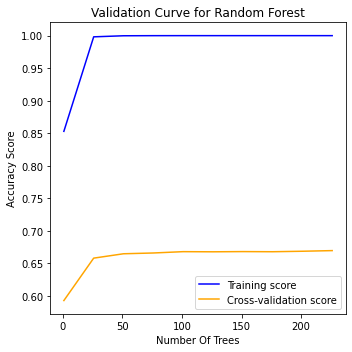

In [100]:
from sklearn.model_selection import validation_curve

# Plot Validation Curve
# Create range of values for parameter
param_range = np.arange(1, 250, 25)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(RandomForestClassifier(),
TrainX, TrainY, param_name="n_estimators", param_range=param_range,
cv=4, scoring="accuracy", n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.subplots(1, figsize=(5,5))
plt.plot(param_range, train_mean, label="Training score", color="Blue")
plt.plot(param_range, test_mean, label="Cross-validation score", color="orange")
# Plot accurancy bands for training and test sets
#plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="orange")
#plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="moccasin")
# Create plot    
plt.title("Validation Curve for Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
ax.set_axis_bgcolor("white")
plt.show()


AttributeError: 'AxesSubplot' object has no attribute 'set_axis_bgcolor'

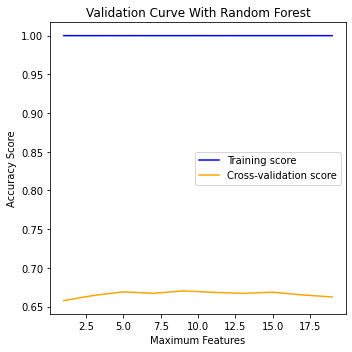

In [101]:
from sklearn.model_selection import validation_curve

# Plot Validation Curve
# Create range of values for parameter
param_range = np.arange(1, 20, 2)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(RandomForestClassifier(),
TrainX, TrainY, param_name="max_features", param_range=param_range,
cv=4, scoring="accuracy", n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.subplots(1, figsize=(5,5))
plt.plot(param_range, train_mean, label="Training score", color="Blue")
plt.plot(param_range, test_mean, label="Cross-validation score", color="orange")
# Plot accurancy bands for training and test sets
#plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="orange")
#plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="moccasin")
# Create plot    
plt.title("Validation Curve With Random Forest")
plt.xlabel("Maximum Features")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
ax.set_axis_bgcolor("white")
plt.show()


Text(0.5, 0, 'Relative Importance')

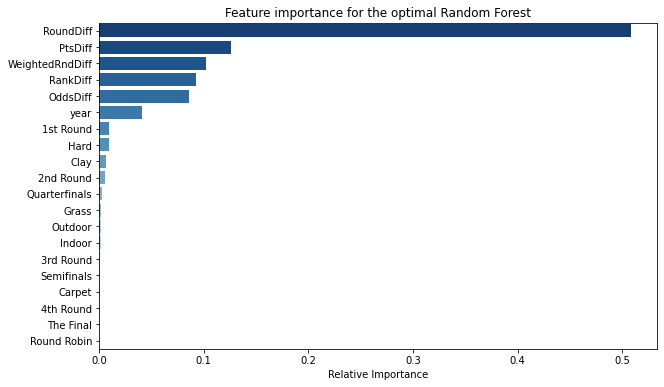

In [102]:
import seaborn as sns
feature_imp = pd.Series(rf_Fit0.feature_importances_, index=TrainX.columns).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(y=feature_imp.index, x=feature_imp,palette = "Blues_r")
plt.title('Feature importance for the optimal Random Forest')
plt.xlabel("Relative Importance")

In [ ]:
cols1 = ["RoundDiff","WeightedRndDiff","PtsDiff","RankDiff","OddsDiff","Year","1st Round","Hard","Clay","2nd Round"]

In [ ]:
#Number of trees in random forest
n_estimators = np.linspace(start = 1200, stop = 3000, num = 10, dtype='int32')
#Number of features to consider at every split
max_features = [5,6,7,8,10]
#Maximum number of levels in tree
max_depth = list(np.linspace(30, 80, num = 5, dtype='int32'))
max_depth.append(None)
#Minimum number of samples required to split a node
min_samples_split = [10, 50, 80]
#Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10, 40]
#Method of selecting samples for training each tree
bootstrap = [True, False]
#Information critereon  
criterion=['gini']ff

In [ ]:
#Random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion' : criterion
              }

In [ ]:
# Random forest Base model to tune
rf_fit = RandomForestClassifier()

In [ ]:
rf_random_fit = RandomizedSearchCV(estimator = rf_fit, param_distributions = random_grid, n_iter = 30, cv = 3, random_state=1995, n_jobs = -1)

In [ ]:
TrainY = TrainY.squeeze()

In [ ]:
# Fit the random search model
rf_random_fit.fit(TrainX, TrainY)

In [ ]:
best_rf = rf_random_fit.best_estimator_

In [ ]:
best_rf

In [ ]:
best_rf.score(X=TestX,y=TestY)

In [ ]:
feature_imp = pd.Series(best_rf.feature_importances_, index=TrainX.columns).sort_values(ascending=False)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.title('Features importance in the optimal Random Forest estimator')